# Задание 1. Классификация обращений пользователей SAP в поддержку

# Постановка задачи и данные

Напомним постановку задачи, которую предстоит решить в первом практическом задании. По тексту обращения необходимо определить пользовательский интент и классифицировать его в один из существующих классов-интентов:

![](img/1_1.png)

Загрузим таблицу с данными. Для считывания данных и их хранения используется библиотека $pandas$, которая предоставляет удобный интерфейс для работы с данными:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

df = pd.read_excel("last_zno_without_ner.xlsx", index=False)
df.head()

,text,class
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71
4,При попытке подписания документа внутри банка ...,1-71


Таблица содержит два поля:
- **text** - Текст обращения пользователя.
- **class** - Класс проблемы, содержащейся в обращении.

Однако, тексты обращений не могут быть использованы как входные данные моделей машинного обучения. Чтобы преобразовать их в необходимый формат, мы должны пройти через три этапа:

![](img/1_2.png)

- **Токенизация** - это процесс выделеения токенов из текста, где в качестве токенов могут выступать символы, слова, словосочетания или предложения. Выше изображена токенизация текста по словам и именно ее мы будем далее использовать.
- После того, как проведена токенизация для каждого обращения, мы получаем набор из большого количества слов. Некоторые из этих слов представляют собой различные формы одного и того же слова. От всех таких слов хочется оставить лишь одного представителя, что происходит при **предобработке** токенов.
- После того, как мы сократили общее число слов, нам необходимо выбрать наиболее информативные слова и сделать их **признаками** текста. Затем каждому обращению мы можем сопоставить вектор, который и будут использовать модели машинного обучения:

![](img/1_3.png)

На $i$-ой компоненте результирующего вектора стоит единица, если $i$-ое слово-признак присутствует в тексте и 0 в обратном случае. Такой вектор называется **признаковым описанием** обращения. Вместе с индикаторными признаковыми описаниями, построение которых мы только что рассмотрели, мы можем использовать частотные: в случае присутсвия слова-признака в тексте мы записываем в соответствующую компоненту вектора не 1, а частоту слова-признака в тексте. Далее в практическом задании мы будем использовать именно частотные признаковые описания.

Теперь более подробно поговорим о каждом этапе преобразования сырого текста обращения пользователя в вектор признакового описания, последовательно применяя описанные этапы к нашим данным.

---

Прежде чем переходить к програмной реализации, опишем несколько основных приемых приемов, которые мы будем использовать в дальнейшем при обработке данных:

- Чтобы применить преобразование к каждому элементу типа $Series$ (такой тип имеют столбцы матрицы  $df$), можно использовать метод $apply()$:

In [2]:
a = Series([1, 2, 3, 4, 5])
function = lambda x : x % 2
a.apply(function)

0    1
1    0
2    1
3    0
4    1
dtype: int64

- Чтобы применить преобразование к каждому элементу типа $list$, можно использовать списковое включение:

In [3]:
a = [1, 2, 3, 4, 5]
[x + 1 for x in a]

[2, 3, 4, 5, 6]

- В списковом включении также можно использовать условие:

In [4]:
a = [1, 2, 3, 4, 5]
[x + 1 for x in a if x > 3]

[5, 6]

# Подготовка данных

## 1. Токенизация

![](images/1_4.png)

Как оговаривалось ранее, мы выбрали в качестве токенов слова и теперь необходимо каждое обращение представить набором содержащихся в нем слов. При этом нет необходимости в прмяом смысле сопоставлять обращению список слов: достаточно выписать все слова, которые встречаются в тексте через пробел и каждому обращению сопоставить такую строку. Тогда мы сможем хранить токенизированные обращения в той же таблице $df$, где хранятся необработанные тексты обращений, всего лишь добавив в таблицу новый столбец.

Итак, нам необходимо каждому обращению сопоставить строку из содержащихся в нем слов, выписанных через пробел.Такая задача сводится к удалению из исходного обращения:
- Символов пунктуации
- Отдельно стоящих чисел

Оговорка "отдельно стоящие" нужна для того, чтобы не удалить из текста, например,  токен "ос1", который содержит цифру, но, тем не менее, имеет важное значение при классификации. Подробнее о таких токенах мы поговорим на этапе осуществления замен в тексте.

### 1.1. Удаление знаков препинания

Произведем удаление символов пунктуации из текстов. Сделаем это с помощью метода $sub$ библиотеки $re$, который удаляет из строки все символы из заданного списка, а также с помощью метода $apply$, который мы обсуждали ранее:

In [2]:
import re

deleted_symols = '[\\\\\'[\]!"$%&()*+,-./:;<=>?@^_`{|}~«»\n]'
func = lambda text : re.sub(deleted_symols, ' ', text)
df["without_punctuation_text"] = df["text"].apply(func)

Проверим, что символы пунктуации были удалены:

In [3]:
df.head()

,text,class,without_punctuation_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается и...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз 2076251...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провест...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...


### 1.2. Удаление отдельно стоящих чисел

### Упражнение 1

**Задание:** Удалите из текстов обращений отдельно стоящие числа по следующему алгоритму:
- Разбейте текст обращения на слова с помощью функции $split()$
- Используя списковое включение удалите из полученного списка числа (для того, чтобы проверить, является ли строка числом используйте метод $isdigit$)
- Преобразуйте список в строку с помощью метода $join()$
- Примените вышеописанные действия к каждому обращению таблицы $df$ с помощью функции $apply()$

In [4]:
#Начало кода
func = lambda text: ' '.join([word for word in text.split() if not word.isdigit()]).strip()
df['without_numbers_text'] = df['without_punctuation_text'].apply(func)
#Конец кода

In [5]:
df.head()

,text,class,without_punctuation_text,without_numbers_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается и...,После оплаты выполнения ЗнЗ не получается испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС,Вопрос проблема Не дает исполнить ЗНС
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз 2076251...,Вопрос проблема Не могу исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провест...,Вопрос проблема Дорбрый день Пытаюсь провести ...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...,При попытке подписания документа внутри банка ...


**Проверка:**

In [6]:
sentence_list = ["ошибка номер", "документ ос1", "12345t6789", ""]
union_res = " ".join([func(sentence) for sentence in sentence_list]).strip()

print("Ответ к упражнению 1:")
print(union_res)

Ответ к упражнению 1:
ошибка номер документ ос1 12345t6789


На это токенизация обращений завершена. Мы можем удалить из таблицы $df$ столбцы, отвечающие промежуточным преобразованиям и оставить только последний вариант:

In [7]:
df["tokenized_text"] = df['without_numbers_text']
df = df.drop(["without_numbers_text", "without_punctuation_text"], axis=1)

In [8]:
df.head()

,text,class,tokenized_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провести ...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...


## 2. Предобработка данных

![](images/1_5.png)

После токенизации нам необходимо привести все слова обращений к некоторой нормальной форме. Такое преобразование включает в себя:
- Приведение символов слов к нижнему регистру
- Приведение слов к нормальной форме с помощью стемминга или лемматизации (будем использовать лемматизацию)
- Осуществление списка заданных замен

Перед началом преобразований посчитаем количество уникальных слов во всех обращениях:

In [9]:
n_words = len(set(" ".join(df["tokenized_text"]).split()))
n_words

34222

Посмотрим, насколько это число изменится после предобработки обращений.

### 2.1 Приведение к нижнему регистру

Приведение всех обращений к нижнему регистру осуществляется с помощью строковго метода $lower$:

In [10]:
df["lowercase_text"] = df["tokenized_text"].apply(lambda text : text.lower())

In [11]:
df.head()

,text,class,tokenized_text,lowercase_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается испо...,после оплаты выполнения знз не получается испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС,вопрос проблема не дает исполнить знс
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз по догов...,вопрос проблема не могу исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провести ...,вопрос проблема дорбрый день пытаюсь провести ...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...,при попытке подписания документа внутри банка ...


### 2.2 Приведение к нормальной форме

После приведения слов обращений к нижнему регистру необходимо лемматизировать обращения. Это можно сделать двумя способами:
- **Способ 1**
    - Создать объект класса $MorphAnalyzer()$
    - Представить обращение списком слов
    - Каждое обращение из списка привести к нормальной форме методом $normal\_form$

- **Способ 2**
    - Создать объект класса $MorphAnalyzer()$
    - Создать список всех слов во всех обращениях
    - Найти уникальные слова (удобно представить список объектом $Series$ и использовать метод $unique()$)
    - Из уникальных слов составить словарь, сопоставляющий нелемматизированным словам лемматизированные
    - Преобразовать все слова во всех обращениях

Существенным преимуществом второго подхода является тот факт, что мы не применяем дорогую операцию преобразования слова к лемматизированной форме к одному и тому же слову несколько раз. К примеру, если некоторое слово встречается в текстах всех обращений 100 раз, (что и происходит для часто употребительных слов) то в первом подходе мы будем лемматизировать его так же 100 раз, а во втором подходе - всего лишь один. Почувствуем разницу в эффективности на практике:

Реализация первого способа выглядит следующим образом:

In [14]:
# !pip3 install pymorphy2

  Using cached pymorphy2-0.8-py2.py3-none-any.whl (46 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
     |████████████████████████████████| 7.1 MB 166 kB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=3c4c5cb8ce516795ae73269298381efa2650cad89d47a66daac47fde4df1aa1c
  Stored in directory: /Users/andrewbelyaev/Library/Caches/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [15]:
import pymorphy2
from pymorphy2 import MorphAnalyzer

def to_lemmatize1(df):
    lemmatizer = MorphAnalyzer()
    lemm_func = lambda text: ' '.join([lemmatizer.normal_forms(word)[0] for word in text.split()])
    df['lemmatized_text'] = df['lowercase_text'].apply(lemm_func)
    
    return df

Проверим время работы первого варианта лемматизации:

In [21]:
# %%time
# df = to_lemmatize1(df)

### Упражнение 2. 
**Задание:** Реализуйте второй вариант приведения к нормальной форме согласно описанному выше алгоритму:

In [16]:
df["lemmatized_text"] = df["lowercase_text"]

In [17]:
def to_lemmatize2(df):
    all_word_str = " ".join(df["lowercase_text"])
    all_word_list = all_word_str.split()
    #Начало кода
    all_unique_word = pd.Series(all_word_list).unique()
    #Конец кода
    lemmatized_word_dict = {}
    lemmatizer = MorphAnalyzer()
    for word in all_unique_word:
        #Начало кода
        lemmatized_word_dict[word] = lemmatizer.normal_forms(word)[0]
        #Конец кода
    lemm_func = lambda text: ' '.join([lemmatized_word_dict[word] for word in text.split()])
    df['lemmatized_text'] = df['lowercase_text'].apply(lemm_func)
    return df, all_unique_word

**Проверка:**

In [18]:
check_df = DataFrame({"lowercase_text" : ["у меня возникла какая-то ошибка", 
                                          "ничего не работает", 
                                          "почему именно у меня проблемы"]})
lem_check_df, vocabulary = to_lemmatize2(check_df)
union_res = " ".join(lem_check_df["lemmatized_text"]).strip()

print("Ответ к упражнению 2:")
print(union_res)

Ответ к упражнению 2:
у я возникнуть какой-то ошибка ничто не работать почему именно у я проблема


Посмотрим на время работы второго способа нормализации и сравним его с первым:

In [19]:
%%time
df, _ = to_lemmatize2(df)

CPU times: user 7.33 s, sys: 130 ms, total: 7.46 s
Wall time: 8.36 s


In [20]:
df.head()

,text,class,tokenized_text,lowercase_text,lemmatized_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается испо...,после оплаты выполнения знз не получается испо...,после оплата выполнение знз не получаться испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС,вопрос проблема не дает исполнить знс,вопрос проблема не давать исполнить знс
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз по догов...,вопрос проблема не могу исполнить знз по догов...,вопрос проблема не мочь исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провести ...,вопрос проблема дорбрый день пытаюсь провести ...,вопрос проблема дорбрый день пытаться провести...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...,при попытке подписания документа внутри банка ...,при попытка подписание документ внутри банка п...


Видно, что второй метод работает намного быстрее. Так что на практике, при необходимости лемматизации слов, нужно использовать именно второй подход.

### 2.3 Осуществление замен

В обращениях пользователей встречаются аббревиатуры, представляющие собой специфичные термины, которые используются только в рамках узкого бизнес-процесса, например:
- ЗНС (заявка на снабжение)
- ЗНВ (заявка на выбытие)
- ЭД (электронный документооборот)

При этом пользователи могут использовать как абревиатуры, так и указывать полное наименование термина. Обработка этих случаев важна для классификации, поэтому необходимо приводить различные формы их написания к единой форме. С этой целью создан файл $abbr\_df.csv$, который содержит два поля:
- target: аббревиатура
- sourse: выражение, которые нужно заменить на аббревиатуру

In [21]:
abbr_df = pd.read_csv('abbr_df.csv', dtype=str)
abbr_df.head()

,source,target
0,запрос на снабжение,знс
1,запрос на выбытие,знв
2,заявка на корректировка,знк
3,запрос на расходование средство,знрс
4,заявка на платёж,знп


### Упражнение 3

**Задание:** Произведите замены в тексте согласно следующему алгоритму:
- Определите функцию, осуществляющую замену для заданного текста (используйте строковый метод $replace$)
- Примените реализованную функцию для осуществления всех замен из таблицы $abbr\_df$:

In [22]:
def abbr_func(text, source, target):
    #Начало кода
    return text.replace(source, target)
    #Конец кода
    
def to_abbr_replace(df):
    df["text_with_abbreviation"] = df["lemmatized_text"]
    for i in range(len(abbr_df)):
        source = abbr_df["source"][i]
        target = abbr_df["target"][i]
        #Начало кода
        df["text_with_abbreviation"] = df["text_with_abbreviation"].apply(lambda text: abbr_func(text, source, target))
        #Конец кода
    return df
        
df = to_abbr_replace(df)

**Проверка:**

In [23]:
check_df = DataFrame({"lemmatized_text" : [" запрос на снабжение ", 
                                          " запрос на выбытие ", 
                                          " запрос на расходование средство "]})
abr_check_df = to_abbr_replace(check_df)
union_res = " ".join(abr_check_df["text_with_abbreviation"]).strip()

print("Ответ к упражнению 3:")
print(union_res)

Ответ к упражнению 3:
знс   знв   знрс


In [24]:
df.head()

,text,class,tokenized_text,lowercase_text,lemmatized_text,text_with_abbreviation
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,После оплаты выполнения ЗнЗ не получается испо...,после оплаты выполнения знз не получается испо...,после оплата выполнение знз не получаться испо...,после оплата выполнение знз не получаться испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,Вопрос проблема Не дает исполнить ЗНС,вопрос проблема не дает исполнить знс,вопрос проблема не давать исполнить знс,вопрос проблема не давать исполнить знс
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,Вопрос проблема Не могу исполнить знз по догов...,вопрос проблема не могу исполнить знз по догов...,вопрос проблема не мочь исполнить знз по догов...,вопрос проблема не мочь исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,Вопрос проблема Дорбрый день Пытаюсь провести ...,вопрос проблема дорбрый день пытаюсь провести ...,вопрос проблема дорбрый день пытаться провести...,вопрос проблема дорбрый день пытаться провести...
4,При попытке подписания документа внутри банка ...,1-71,При попытке подписания документа внутри банка ...,при попытке подписания документа внутри банка ...,при попытка подписание документ внутри банка п...,при попытка подписание документ внутри банка п...


На этом предобработка обращений завершена. Мы можем удалить из таблицы $df$ столбцы, отвечающие промежуточным преобразованиям и оставить только последний вариант:

In [25]:
df["transformed_text"] = df["text_with_abbreviation"]

In [26]:
df = df.drop(["tokenized_text", "lowercase_text", "lemmatized_text", "text_with_abbreviation"], axis=1)
df.head()

,text,class,transformed_text
0,"После оплаты , выполнения ЗнЗ, не получается и...",1-1,после оплата выполнение знз не получаться испо...
1,Вопрос/проблема: Не дает исполнить ЗНС,1-1,вопрос проблема не давать исполнить знс
2,Вопрос/проблема: Не могу исполнить знз 2076251...,1-22,вопрос проблема не мочь исполнить знз по догов...
3,Вопрос/проблема: Дорбрый день! Пытаюсь провест...,1-71,вопрос проблема дорбрый день пытаться провести...
4,При попытке подписания документа внутри банка ...,1-71,при попытка подписание документ внутри банка п...


В конце посмотрим, насколько нам удалось сократить количество уникальных слов:

In [27]:
new_n_words = len(set(" ".join(df["transformed_text"]).split()))
print("количество уникальных слов до обработки обращений:", n_words)
print("количество уникальных слов после обработки обращений:", new_n_words)

количество уникальных слов до обработки обращений: 34222
количество уникальных слов после обработки обращений: 17509


Видно, что мы сокралили количество уникальных слов практически в два раза.

---

## 3. Выделение признаков (Векторизация)

Перейдем к этапу выделеения признаков из текста:

![](img/1_6.png)

Выделение признаков является финальной частью векторизации:

![](img/1_3.png)

Мы рассмотрим два этапа отбора признаков:
- На **первом этапе** мы отбираем большое количество признаков по частоте их встречаемости в текстах всех обращений.
- На **втором этапе** из большого числа признаков отбираем наиболее важных признаки с помощью трех методов:
    - Статистическое оценивание важности признака.
    - Логистическая Регрессия (с помощью $l_1$ регуляризатора).
    - Случайный лес (с помощью флага $oob\_score$).

После первого этапа отбора признаков мы сможем получить из исходной таблицы $df$ два объекта:
-  $X \in R^{n \times m}$ - матрицу объекты-признаки ($n$ - количество объектов, $m$ - количество признаков)
- $y \in R^{n}$ - вектор правильных ответов

Наличие пары $(X, y)$, уже позволит нам применить методы стандартного машинного обучения, которые мы обсуждали в курсе, и получить некоторое начальное решение для дальнейших методов отбора признаков. Далее каждый метод из второго этапа будет лишь уточнять матрицу объекты-признаки $X$ (а именно, удалять из нее некоторые столбцы, соответствующие неинформативным признакам). После каждого метода на паре $(\overline{X}, y)$ с измененной матрицей объекты-признаки $\overline{X}$, мы будем обучать те же алгоритмы машинного обучения и смотреть, как изменяется их точность. Если точность будет возрастать, то это будет с высокой вероятностью означать, что мы удалили неинформативные признаки и помогли классификации.

Основными методами проверки точности модели является использование отложенной выборки и кроссвалидации. Отложенная выборка предполагает разбиение всех имеющихся данных на две части, на одной из которых происходит обучение модели, а на другой - проверка ее точности. Кроссвалидация предполагает повтор описанной операции несколько раз - мы делим всю выборку $(X, y)$ на $N$ частей, после чего обучаемся на $N-1$ части и находим точность на оставшейся. Такую процедуру повторяют $N$ раз, после чего получают N значений точности и усредняют результат. 

![](img/1_7.png)

Чтобы сократить время обучения моделей, для оценки точности мы будем использовать отложенную выборку.

### 3.1 Первый этап (Отбор частотных слов +  Векторизация)

Для выделения частотных признаков удобно использовать объект $CountVectorizer$. Для того, чтобы отобрать признаки по частоте, достаточно задать два важных параметра :
- $min\_df$: Минимальная частота, которой должно обладать слово, чтобы стать признаком.
- $ngram\_range$: Пара чисел, означающая какой диапазон n-грамм мы хотим использовать. В случае $ngram\_range = (1, 1)$ в качестве кандидата на место признака будут рассматриваться только слова, а, например, при $ngram\_range = (1, 2)$ признаками станут и слова, и биграммы, преодолевшие заданный порог частоты.

Для нашей задачи зададим следующие параметры: $ngram\_range=(1, 5)$. Можно задать сколь угодно большой диапазон n-грамм не боясь сльно увеличить количество признаков, поскольку в любом случае всем n-граммам затем необходимо будет превзойти заданный порог частоты. А вот параметр $min\_df$ необходимо выбрать более аккуратно: при слишком маленьких значениях мы получим неоправданно большое количество признаков, что осложноит дальнейшее применение моделей машииного обучения, а при слишком больших значениях мы можем упустить значимые слова, которые всречаются малое число раз.

Чтобы решить описанную неопределенность, запустим векторизацию с различными значениями $min\_df$ и выберем минимальное, при котором матрица объекты-признаки будет приемлемого размера:

Выберем параметр $min\_df = 30$ и произведем окончательную векторизацию:

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
MAX_N_GRAMM = 5

vectorizer = CountVectorizer(min_df=30, ngram_range=(1, MAX_N_GRAMM))
X = vectorizer.fit_transform(df["transformed_text"])
y = df["class"].values
print("размерность матрицы объекты-признаки:", X.shape)

размерность матрицы объекты-признаки: (19312, 4213)


Разобьем все имеющиеся данные на обучающую и проверочную выборки:

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, y, stratify=y, test_size=0.2)
print("===== полученные размерности =====")
print("X_train.shape:", X_train.shape)
print("X_dev.shape:", X_dev.shape)
print("y_train.shape:", y_train.shape)
print("y_dev.shape:", y_dev.shape)

===== полученные размерности =====
X_train.shape: (15449, 4213)
X_dev.shape: (3863, 4213)
y_train.shape: (15449,)
y_dev.shape: (3863,)


Проверим качество выбранного признакового описания. Обучим модели на обучающей выборке $(X\_train, y\_train)$, и проверим их точность на отложенной выборке $(X\_dev, y\_dev)$. Точность каждой модели на отложенной выборке можно узнать с помощью метода $accuracy\_score$. Точность каждой модели будем сохранять в словаре $scores$. Эта информация будет необходима, когда мы будем оценивать качество последующих методов отбора признаков.

**Внимание:** обучение можеть занять достаточное время.

In [30]:
%%time
#methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
#scores
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
lr = LogisticRegression()
svc = SVC(kernel="linear")
knn = KNN(n_neighbors=1)
nb = GaussianNB()

scores = {}
for name, clf in [("random forest", rfc), 
                  ("logistic regression", lr),
#                   ("SVM", svc),
#                   ("knn", knn),
#                   ("naive bayes", nb)
                 ]:
    if name == "naive bayes":
        clf.fit(X_train.toarray(), y_train)
        scores[name] = accuracy_score(y_dev, clf.predict(X_dev.toarray()))
    else:
        clf.fit(X_train, y_train)
        scores[name] = accuracy_score(y_dev, clf.predict(X_dev))
    print(name, scores[name])

random forest 0.7180947450168264
logistic regression 0.7535594097851411
CPU times: user 1min 6s, sys: 5.26 s, total: 1min 11s
Wall time: 1min 1s


Чтобы сократить время обучения моделей, далее при анализе методов машинного обучения будем использовать только две модели: $Random Forest$ и $Logistic Regression$.

### 3.2 Второй этап (Применение методов отбора признаков)

Итак, теперь у нас есть список слов, которые стали признаками в результате частотного отбора. Создадим список таких слов в порядке их следования в матрице объекты-признаки $X$:

In [31]:
vocabulary = list(Series(vectorizer.vocabulary_).keys())
vocabulary[:10]

['после',
 'оплата',
 'выполнение',
 'знз',
 'не',
 'получаться',
 'исполнить',
 'знс',
 'знз не',
 'не получаться']

Теперь нам необходимо произвести отбор признаков поверх частотного отбора с помощью трех методов, которые мы указывали выше. Заведем словарь, который для каждого метода будет хранить все слова-признаки с соотвествующими оценками значимости:

In [32]:
feature_imporances = {}

Для того, чтобы проверить качество стандартных моделей машинного обучения после реализованного отбора признаков, будем создавать новый объект $CountVectorizer$ с заданным параметром $vocabulary$ - списком отобранных слов, которые мы хотим сделать признаками. В качестве отобранных слов мы будем выбирать первые $n\_features$ слов в порядке их значимости согласно каждому методу, где $n\_features$ будет принимать следующие значения:

In [33]:
n_features_list = np.arange(500, 2100, 300)

Заранее напишем две функции, каждая из которых для фиксированного метода отбора признаков:
- возвращает точность моделей для $n\_featutres$ признаков для каждого значения $n\_featutres$ из $n\_features\_list$
- отрисовывает зависимость точности моделей от количества значимых признаков и сравненивает эту точность с точностью моделей без отбора признаков (точнее, только с частотным отбором)

In [34]:
def get_accuracy_list(feature_imporances, vocabulary=vocabulary, n_features_list=n_features_list):
    accuracy_list = {"random forest" : [], "logistic regression" : []}
    for n_features in n_features_list:
        print("===== n_features:", n_features, "=====")
        usefull_features = feature_imporances.keys()[:n_features]
        usefull_features_indexes = [i for i in range(len(vocabulary)) if vocabulary[i] in usefull_features]
        #print(usefull_features_indexes)
        decreased_X_train = X_train[::, usefull_features_indexes]
        decreased_X_dev = X_dev[::, usefull_features_indexes]
        for name, clf in [("random forest", rfc), ("logistic regression", lr)]:
            clf.fit(decreased_X_train, y_train)
            accuracy_list[name].append(accuracy_score(y_dev, clf.predict(decreased_X_dev)))
            
    return accuracy_list

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def print_results(accurasy_list, n_features_list=n_features_list, scores=scores):
    plt.figure(figsize=(10, 5))
    for name in accurasy_list.keys():
        plt.plot(n_features_list, accurasy_list[name])
    for name in accurasy_list.keys():
        plt.plot(n_features_list, np.full(len(n_features_list), scores[name]))
    plt.xlabel("количество признаков")
    plt.ylabel("точность")
    plt.legend(list(accurasy_list.keys()) + [name + " без отбора признаков" for name in list(accurasy_list.keys())])

Теперь последовательно применим каждый из методов отбора признаков.

### 3.2.1 Статистическое оценивание

Напомним, что в статистическом оценивании мы проеряем следующие гипотезы для каждого признака:
- гипотеза $H_0$ : признак является незначимым (признак и целевая переменная являются независимыми случайными величинами)
- гипотеза $H_1$ : признак значим

После проверки гипотезы может сформироваться 4 возможные ситуации:

![](img/1_8.png)

По величине $p-value$ мы можем сделать вывод о значимости признака:
 - если $p-value$ принимает относительно большие значения, то это означает следующее: большая вероятность того, что гипотеза $H_0$ неверно отвергнута. То есть, большая вероятность того, что $H_0$ верна и признак с большой вероятность является незначимым.
 - если $p-value$ принимает относительно малые значения, то это означает, что вероятность того, что гипотеза $H_0$ неверно отвергнута мала. То есть $H_0$ отвергнута по существу и признак с высокой вероятностью значим.

Реализуем статистический метод отбора признаков применительно к нашим данным:

Найдем величины $p-value$ для каждого признака с помощью метода $chi2$:

In [36]:
from sklearn.feature_selection import chi2

p_values = chi2(X_train, y_train)[1]

Затем отсортируем все признаки по величинам $p-value$ и посмотрим на несколько первых и несколько последних признаков в этом списке:

In [37]:
feature_imporances["p-value"] = Series(p_values, index=vocabulary).sort_values()
feature_imporances["p-value"][:10]

по новый                             0.0
право мол                            0.0
по это                               0.0
инициатор                            0.0
добрый день как                      0.0
фио фио руководитель направление     0.0
руководитель направление             0.0
ошибка дать                          0.0
дать гп спецификация не совпадать    0.0
где                                  0.0
dtype: float64

In [38]:
feature_imporances["p-value"][-10:]

текущий обработчик      0.945465
назначение мол          0.954019
учитывать гп            0.958264
реализовать             0.959250
при нажатие на          0.984532
орг                     0.987466
отправляться            0.990447
для исполнение          0.991097
согласование договор    0.991681
по запрос               0.991682
dtype: float64

Кажется, что отбор признаков прошел успешно. Проверим, точность моделей на сокращенном признаковом описании:

===== n_features: 500 =====
===== n_features: 800 =====
===== n_features: 1100 =====
===== n_features: 1400 =====
===== n_features: 1700 =====
===== n_features: 2000 =====
CPU times: user 3min 52s, sys: 26.8 s, total: 4min 19s
Wall time: 3min 23s


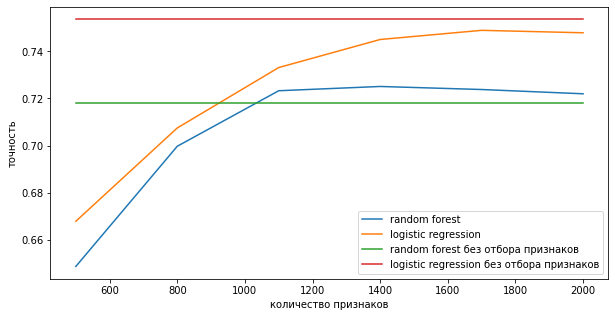

In [39]:
%%time
accurasy_list = get_accuracy_list(feature_imporances["p-value"])
print_results(accurasy_list)

### 3.2.2 Оценивание с использованием Случайного леса

Вспомним схему работу случайного леса в случае, когда мы устанавливаем флаг $oob\_score$ значением $True$:
- Все множество объектов $X$ разбивается на два множества : $X'$ и $X''$
- Множество $X'$ используется при обучении (по случайному подмножеству признаков)
- Множество $X''$ используется при проверке качества (в частности, качества выбранных признаков)

![](img/1_9.png)

Произведем описанную процедуру:

In [40]:
clf = RandomForestClassifier(oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

Отсортируем признаки и посмотрим на самые значимые и самые незначимые из них:

In [41]:
feature_imporances["random forest with oob"] = Series(clf.feature_importances_, 
                                                      index=vocabulary).sort_values(ascending=False)

In [42]:
feature_imporances["random forest with oob"][:10]

исполнение не          0.020699
какой то               0.013710
создание знс не        0.013228
дальнейший действие    0.009323
уважаемый              0.009089
подобный               0.006469
который не             0.006419
кто на                 0.006128
внести                 0.005421
реконструкция          0.005282
dtype: float64

In [43]:
feature_imporances["random forest with oob"][-10:]

необходимый провести    0.0
цкп рсц                 0.0
знв на                  0.0
договор sap             0.0
переместить             0.0
не меняться             0.0
наличие тмц за          0.0
за подотчётный лицо     0.0
график                  0.0
по новый                0.0
dtype: float64

Оценим точность моделей:

===== n_features: 500 =====
===== n_features: 800 =====
===== n_features: 1100 =====
===== n_features: 1400 =====
===== n_features: 1700 =====
===== n_features: 2000 =====
CPU times: user 5min 5s, sys: 29.3 s, total: 5min 34s
Wall time: 4min 16s


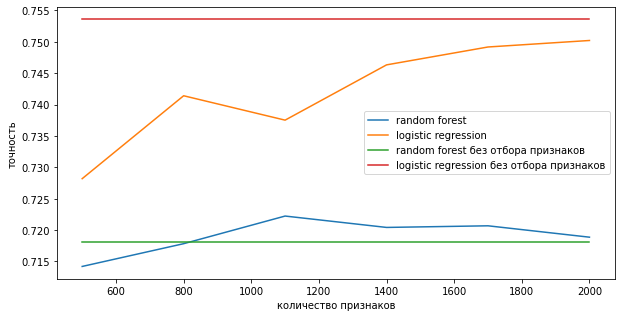

In [44]:
%%time
rfc_accurasy_list = get_accuracy_list(feature_imporances["random forest with oob"])
print_results(rfc_accurasy_list)

### 3.2.3 Оценивание с использованием Логистической регрессии

Оценивание с использование логистической регрессии подразумевает использованим  $l_1$ регуляризатора. Суть регуляризаторов в следующем. Решающее правило для логичтисеко регрессии имеет следующий вид:

$$
a(x) = sign(<w, x> - b)
$$

Для применения метода, необходимо настроить параметры $(w, b)$, что и присходит при обучении путем минимизации функции потерь:

$$
L(w, b) \rightarrow min
$$

Однако, может случиться так, что функция $L(w, b)$ принимает малые значения на обучающей выборке, но на отложенных данных (или на кроссвалидации), точность модели падает. Это говорит о переобучении. Чтобы избежать такого эффекта, к минимизируемой функции $L(w)$ добавляет слагаемое, которое зависит только от вектора весов $w$. Основными типами регуляризации является $l_1$ и $l_2$ регуляризация:

$$
l_1 : L(w, b) + C \cdot \sum{|w_i|} \rightarrow min
$$
$$
l_2 : L(w, b) + C \cdot \sum{w_i^2} \rightarrow min
$$

Отбору признаков способствует именно $l_1$ регуляризация. Отбор признаков происходит за счет того, что некоторые компоненты вектора весов $w$ становятся равны нулю, в результате чего соотвествующие признаки не принимают участия в классификации. На количество оставшихся признаков вляет константа $C$ : чем она больше, тем больше значение придается регуляризации и тем меньше признаков остается. Мы будем использовать значение $C = 0.1$, но Вы можете изменить его и посмотреть, как это будет влиять на результат.

In [46]:
C = 0.1
clf = LogisticRegression(penalty='l1', C=C, solver='liblinear')
clf.fit(X_train, y_train)
feature_imporances["logistic regression"] = Series(np.abs(clf.coef_).sum(0), 
                                                                    index=vocabulary).sort_values(ascending=False)

Посмотрим на "лучшие" и "худшие" слова:

In [47]:
feature_imporances["logistic regression"][:10]

исполнение не                28.829452
дальнейший действие          28.608548
который не                   26.840425
уважаемый                    26.497818
предпринять                  22.904676
просить сообщить             20.018948
создание знс не              16.790655
подобный                     14.240594
выбытие                      14.122463
проблема добрый день быть    13.188481
dtype: float64

In [48]:
feature_imporances["logistic regression"][-10:]

закрытый договор    0.0
сегодняшний день    0.0
номер на            0.0
заявка на роль      0.0
на роль             0.0
не назначить        0.0
поволжский          0.0
оформлять           0.0
руководитель мвз    0.0
после               0.0
dtype: float64

Проверим точность моделей:

===== n_features: 500 =====
===== n_features: 800 =====
===== n_features: 1100 =====
===== n_features: 1400 =====
===== n_features: 1700 =====
===== n_features: 2000 =====
CPU times: user 4min 40s, sys: 28.9 s, total: 5min 9s
Wall time: 3min 52s


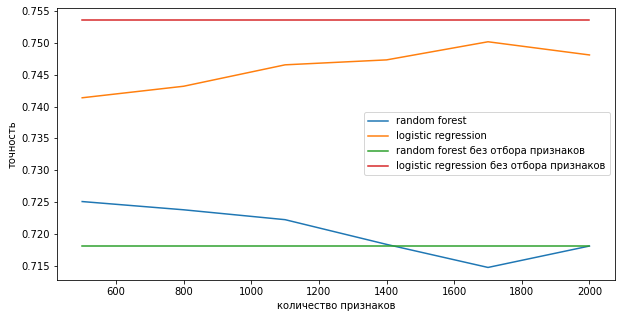

In [49]:
%%time
log_reg_accurasy_list = get_accuracy_list(feature_imporances["logistic regression"])
print_results(log_reg_accurasy_list)

В дальнейшем, при оптимизации и смешивании алгоритмов мы будем использовать 1200 признаков, отобранные логистической регрессией. Вы можете использовать другое количество признаков при другом методе отбора, если в ваших экспериментах другие методы показывают лучший результат.

In [50]:
usefull_features = feature_imporances["logistic regression"][:1200]
usefull_features_indexes = [i for i in range(len(vocabulary)) if vocabulary[i] in usefull_features]
#print(usefull_features_indexes)
dec_X_train = X_train[::, usefull_features_indexes]
dec_X_dev = X_dev[::, usefull_features_indexes]
print("===== полученные размерности =====")
print("dec_X_train.shape:", dec_X_train.shape)
print("dec_X_dev.shape:", dec_X_dev.shape)

===== полученные размерности =====
dec_X_train.shape: (15449, 1200)
dec_X_dev.shape: (3863, 1200)


---

# Оптимизация алгоритмов

Сокращение признакового опиcание не является единственным методом увеличения точности моделей. Вспомним слайд из лекций:

![](img/1_10.png)

Так что после отбора признаков попробуем оптимизировать каждую из моделей машинного обучения за счет оптимального выбора гиперпараметров. Вспомним основные гиперпараметры каждого из методов:

![](img/1_11.png)

Существует два метода отбора гиперпараметров:
- Перебор по сетке (перебираются всевозможные наборы указанных гиперпараметров)
- Рандомизированный перебор (перебирается случайная часть наборов)

В нашем практическом задании мы будем использовать перебор по сетке. Рандомизированный перебор реализуется аналогичным способом. Вспомним последовательность действий при осуществлении перебора по сетке:
- Задаем значения параметров, которые хотим перебрать
- Создаем объект $GridSearchCV$
- Перебираем все наборы гиперпараметров
- Получаем лучший алгоритм

Лучшие алгоритмы будем записывать в словарь $best\_clf$, а соотвествующие точности на отложенной выборке $best\_accuarcy$:

In [51]:
best_clf = {}
best_accuracy = {}

По описанному плану произведем оптимизацию логистической регрессии:

In [52]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {"C" : [0.01, 0.1, 1], "penalty" : ["l1", "l2"]}
lr_clf = LogisticRegression()
lr_gs = GridSearchCV(lr_clf, param_grid)
lr_gs.fit(dec_X_train, y_train)

CPU times: user 5min 17s, sys: 51.7 s, total: 6min 9s
Wall time: 2min 25s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2']})

Посмотрим на оптимальные гиперпараметры и точность лучшего алгоритма на кроссвалидации:

In [53]:
lr_gs.best_params_, lr_gs.best_score_

({'C': 1, 'penalty': 'l2'}, 0.7361640899276167)

Сохраним лучшую модель и ее точность на отложенной выборке:

In [54]:
best_clf["logistic regression"] = lr_gs.best_estimator_
best_accuracy["logistic regression"] = accuracy_score(y_dev, best_clf["logistic regression"].predict(dec_X_dev))
print("optimized logistic regression accuracy:", best_accuracy["logistic regression"])

optimized logistic regression accuracy: 0.7476054879627233


### Упражнение 4

**Задание:** Реализуйте аналогичный перебор гиперпараметров для модели $Random Forest$.

**Замечание:** У модели $Random Forest$ не нужно указывать большие значения для гиперпараметра $n\_estimatiros$. Можно оптимизировать все остальные гиперпараметры при небольшом количестве деревьев (например, при $n\_estimatiros = 100$), зафиксировать их и затем увеличить количество деревьев.

Сохраним лучшую модель и ее точность на отложенной выборке:

$Random Forest$:

In [55]:
%%time
## Начало кода
param_grid = {'min_samples_leaf': [1, 3, 5]}
rf_clf = RandomForestClassifier(n_estimators=100)
rf_gs = GridSearchCV(rf_clf, param_grid)
rf_gs.fit(dec_X_train, y_train)
## Конец кода

CPU times: user 2min 22s, sys: 4.14 s, total: 2min 26s
Wall time: 2min 27s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 3, 5]})

Посмотрите на оптимальные гиперпараметры и точность лучшего алгоритма на кроссвалидации:

In [56]:
## Начало кода
rf_gs.best_params_, rf_gs.best_score_## Конец кода

({'min_samples_leaf': 1}, 0.7107254575951204)

Увеличьте количество деревьев в ансамбле:

In [57]:
## Начало кода
rf_clf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=rf_gs.best_params_['min_samples_leaf'])
## Конец кода

Сохраните обученную модель и ее точность на отложенной выборке:

In [58]:
## Начало кода
best_clf["random forest"] = rf_gs.best_estimator_
best_accuracy["random forest"] = accuracy_score(y_dev, best_clf["random forest"].predict(dec_X_dev))
print("optimized random forest accuracy:", best_accuracy["random forest"])
## Конец кода

optimized random forest accuracy: 0.7162826818534818


**Проверка:**

In [59]:
assert best_accuracy["random forest"] > 0.65
print("Реузльтат неоптимизированной модели превзойден!")

Реузльтат неоптимизированной модели превзойден!


# Смешивание алгоритмов

После того, как мы выбрали признаковое описание и оптимизировали каждый из алгоритмов, мы можем попытать улучшить качество моделей за счет объедиения нескольких алгоритмов. Вспомним основные методы объединения:
- Объединение по предсказаниям (из ответов нескольких алгоритмов выбираем то, которое встречалось чаще других)
- Объединение по вероятностям

Первый вариант объединения имеет несколько недостатков: 
- Неоднозначность классификации (если модели отдают равное количество голосов за несколько классов)
- Трудности с определением вероятности предсказания

Так что в нашем практическом задании мы будем реализовывать втрой метод. Пусть мы имеем два обученных алгоритма: $p_1(x)$ и $p_2(x)$. Тогда для их объекдинения по вероятностям необходимо следующее:
- Создаем модель, объединяющую две модели машинного обучения
- Задаем параметр смешивания $\alpha$
- Выдаем предсказание по правилу $\alpha \cdot p_1(x) + (1 - \alpha) \cdot p_2(x) $
- Настраиваем гиперпараметр $\alpha$ с помощью перебора по сетке


Напишем класс для объединения двух моделей:

In [60]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Mixer(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, alpha=0.5, threshold=0.5, classes=np.array(sorted(list(set(y_train))))):
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha
        self.classes = classes
        
        self.threshold = threshold
        
    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        
    def predict_proba(self, X):
        
        return self.clf1.predict_proba(X) * self.alpha + self.clf2.predict_proba(X) * (1 - self.alpha)
    
    def predict(self, X):
        prob_prediction = self.predict_proba(X)
        
        return self.classes[prob_prediction.argmax(1)]
    
    def get_params(self, deep = False):
        
        return {'clf1' : self.clf1, 'clf2' : self.clf2, 'alpha' : self.alpha}
    
    def set_params(self, alpha):
        
        self.alpha = alpha
        return self

Объединим оптимизированный случайный лес с оптимизированной логистической регрессией:

In [61]:
mix = Mixer(best_clf["random forest"], best_clf["logistic regression"])

Параметр $alpha$ можно настроить с помощью перебора по сетке:

In [62]:
# %%time
# from sklearn.model_selection import RandomizedSearchCV
# ## Начало кода
# param_grid = {"alpha" : [np.arange(0, 1.1, 0.2)]}
# mix_gs = GridSearchCV(mix, param_grid)
# mix_gs.fit(dec_X_train, y_train)

Но в целях экономии времени мы не будем этого делать. Подставим параметр $alpha = 0.3$:

In [63]:
%%time
mix = Mixer(best_clf["random forest"], best_clf["logistic regression"], alpha=0.3)
mix.fit(dec_X_train, y_train)
accuracy_score(mix.predict(dec_X_dev), y_dev)

CPU times: user 47.1 s, sys: 4.2 s, total: 51.3 s
Wall time: 31.8 s


0.756406937613254

Посмотрим на результат на отложенной выборке:

In [64]:
accuracy_score(mix.predict(dec_X_dev), y_dev)

0.756406937613254

### Упражнение 5
**Задание:** Смешайте только что полученную смесь логистичсекой регрессии и случайного леса с любым другим алгоритмом. Параметры добавленного алгоритма и новую величину $alpha$ можно настроить либо перебором по сетке или рандомизированным перебором (что займет достаточное количество времени), либо подобрать вручную. Удается ли улучшить результат?

In [65]:
## Начало кода
#bullshitt отвалилось все в 1000000 раз и не сохранилось
##Конец кода

# Нейронная сеть прямого распространения

В этом пункте мы попробуем применить к решению задачи нейронные сети прямого распространения.

![](img/1_12.png)

Изначально необходимо определить архитектуру сети:
- Количество слоев в нейронной сети
- Количество нейронов на каждом слое
- Функции активации для каждого слоя

После того, как определена архитектура, мы можем приступить к обучению сети. Обучение сети состоит из прямого и обратного распространения ошибки:
- Во время **прямого распространения** для каждого объекта мы должны посчитать значения всех нейронов слева направо, найти предсказание нейронной сети. Затем, на основе предсказаний посчитать функцию потерь для каждого объекта, а затем и суммарную функцию потерь
- После того, как мы нашли функцию потерь, нам необходимо найти ее производные, чтобы применить метод градиентного спуска. Производные функции потерь вычисляются ноборот, справа налево, что происходит во время **обратного распространения**. С помощью вычисленных производным мы можем совершить итерацию градиентного спуска и обновить внутренние параметры сети.

![](img/1_13.png)

Реализуем небольшую нейронную сеть прямого распространения с помощью фреймворка $keras$.

Определим архитектуру сети:

In [67]:
# !pip3 install keras

     |████████████████████████████████| 269 kB 138 kB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-macosx_10_14_x86_64.whl size=44627 sha256=8a95aa9775d3efa8908fb39089c2560714ab278c696cc80de088241ff92b57bb
  Stored in directory: /Users/andrewbelyaev/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyyaml


In [68]:
import keras
import keras.layers as L
from keras.models import Sequential

N_FEATURES = X_train.shape[1]
N_CLASSES = len(set(y_train))
ffnn = Sequential()
ffnn.add(L.Dense(N_CLASSES, input_shape = (N_FEATURES,)))
ffnn.add(L.Activation('softmax'))

In [72]:
N_FEATURES

4213

In [73]:
N_CLASSES

77

Описание полученной архитектуры можно получить с помощью метода $summary$:

In [69]:
ffnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 77)                324478    
_________________________________________________________________
activation (Activation)      (None, 77)                0         
Total params: 324,478
Trainable params: 324,478
Non-trainable params: 0
_________________________________________________________________


Теперь нам необходим скомпилировать нашу модель. Компиляция включает в себя:
- Вид функции потерь
- Вид оптимизатора градиентного спуска
- Метрику (необходимо, чтобы проверять точность нейронной сети на отложенной выборке после каждой эпохи)

In [70]:
ffnn.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

Теперь мы можем начать обучать нашу сеть с помощью метода $fit$. Параметры метода:
- Обучающая выборка $(X\_train, y\_train)$
- Размер батча $batch\_size$
- Проверочная выборка $(X\_dev, y\_dev)$ (для оценивания точности после каждой эпохи)
- Количество эпох $epochs$
- Параметр $verbose$ - нужно ли выводить информацию об обучении ($verbose = 1$) или нет ($verbose = 0$)

In [75]:
from pandas import get_dummies

history = ffnn.fit(X_train.toarray(), get_dummies(y_train).values,
         batch_size=256,
         validation_data = (X_dev.toarray(), get_dummies(y_dev).values),
         epochs=20,
         verbose=1)

Epoch 1/20
61/61 [==============================] - 1s 24ms/step - loss: 0.5199 - accuracy: 0.9467 - val_loss: 1.3119 - val_accuracy: 0.7085
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 0.4960 - accuracy: 0.9497 - val_loss: 1.2999 - val_accuracy: 0.7090
Epoch 3/20
61/61 [==============================] - 1s 17ms/step - loss: 0.4738 - accuracy: 0.9523 - val_loss: 1.2892 - val_accuracy: 0.7111
Epoch 4/20
61/61 [==============================] - 1s 17ms/step - loss: 0.4532 - accuracy: 0.9546 - val_loss: 1.2794 - val_accuracy: 0.7116
Epoch 5/20
61/61 [==============================] - 1s 16ms/step - loss: 0.4341 - accuracy: 0.9568 - val_loss: 1.2714 - val_accuracy: 0.7132
Epoch 6/20
61/61 [==============================] - 1s 17ms/step - loss: 0.4163 - accuracy: 0.9587 - val_loss: 1.2633 - val_accuracy: 0.7132
Epoch 7/20
61/61 [==============================] - 1s 17ms/step - loss: 0.3995 - accuracy: 0.9610 - val_loss: 1.2555 - val_accuracy: 0.7132
Epoch 8/20
61

In [76]:
history.history["val_acc"][-1]

KeyError: 'val_acc'

### Упражнение 6

**Задание:** Реализуйте собственную архитектуру нейронной сети прямого распространения и попытайтесь уровень в 74% правильно классифицированных обращений. Рекомендации к реализации:
- Реализуйте более сложные архитектуры (увеличьте количество слоев, количество нейронов на каждом слое). Учитывайте, что обычно увеличивают количество слоев сети, а затем количество нейронов на псоелднем слое. Удается ли повысить точность модели за счет усложнения ее архитектуры? До какого момента растет точность на отложенных данных?
- Попробуйте различные функции активации скрытых слоев ($relu$, $tanh$)
- Опредлите, ваша модель недообучается (точность на тренировочносй выборке мала) или переобучается(точность на тренировочном множестве мала, но точность на отложенной выборке велика)
- В случае недообучения используйте следующие методики:
    - Инициализациz полносвязных слоев (параметры $kernel\_initializer$ и $bias\_initializer$)
    - Оптимизаторы градиентного спуска ($adam$ во многоих задачах являестя оптимальным решением, но Вы можете использовать и другие оптимизаторы: $adadelta$, $RMSprop$ и другие)
    - Нормализация весов (между полносвязными слоями Вы можете добавить слой $L.BatchNormalization()$)
- В случае переобучения:
    - Введение регуляризации ($kernel\_regularizer$ и $bias\_regularizer$)
    - Введение $dropout$ слоя ($L.Dropout()$)

In [134]:
N_CLASSES, N_FEATURES

(77, 4213)

In [164]:
#Начало кода
inputs = keras.Input(shape=(N_FEATURES,))
dense = L.Dense(1000, activation='softmax')(inputs)
# outputs = L.Dropout(.4)(dense)
outputs = L.Dense(N_CLASSES, activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs, name="first_model")
model.summary()
#Конец кода

Model: "first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 4213)]            0         
_________________________________________________________________
dense_31 (Dense)             (None, 1000)              4214000   
_________________________________________________________________
dense_32 (Dense)             (None, 77)                77077     
Total params: 4,291,077
Trainable params: 4,291,077
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [166]:
history = model.fit(X_train.toarray(), get_dummies(y_train).values,
         batch_size=256,
         validation_data=(X_dev.toarray(), get_dummies(y_dev).values),
         epochs=30,
         verbose=1)

Epoch 1/30
61/61 [==============================] - 5s 88ms/step - loss: 4.3124 - accuracy: 0.1158 - val_loss: 4.2789 - val_accuracy: 0.1232
Epoch 2/30
61/61 [==============================] - 5s 84ms/step - loss: 4.2460 - accuracy: 0.1292 - val_loss: 4.2079 - val_accuracy: 0.1421
Epoch 3/30
61/61 [==============================] - 5s 84ms/step - loss: 4.1606 - accuracy: 0.1555 - val_loss: 4.1051 - val_accuracy: 0.1672
Epoch 4/30
61/61 [==============================] - 5s 87ms/step - loss: 4.0383 - accuracy: 0.1684 - val_loss: 3.9694 - val_accuracy: 0.1750
Epoch 5/30
61/61 [==============================] - 5s 90ms/step - loss: 3.8953 - accuracy: 0.1765 - val_loss: 3.8288 - val_accuracy: 0.1781
Epoch 6/30
61/61 [==============================] - 6s 99ms/step - loss: 3.7543 - accuracy: 0.1712 - val_loss: 3.6984 - val_accuracy: 0.1745
Epoch 7/30
61/61 [==============================] - 7s 108ms/step - loss: 3.6246 - accuracy: 0.1786 - val_loss: 3.5823 - val_accuracy: 0.1799
Epoch 8/30
6

**Проверка:**

In [168]:
test_scores = model.evaluate(X_train.toarray(), get_dummies(y_train).values, verbose=2)

483/483 - 5s - loss: 2.1843 - accuracy: 0.3726


In [169]:
test_scores = model.evaluate(X_dev.toarray(), get_dummies(y_dev).values, verbose=2)

121/121 - 1s - loss: 2.3964 - accuracy: 0.3311


In [187]:
y_dev[0]

'2-14'

In [183]:
np.argmax(model.predict(X_dev.toarray())[0])

27

In [186]:
np.unique(df['class'])[27]

'2-14'

In [92]:
assert history.history["val_accuracy"][-1] > 0.74
print("Проверка пройдена!")

AssertionError: 

---

# RNN with Word2Vec embeddings

В этом пункте мы применим двунаправленную нейронную сеть долгой краткосрочной памяти, на вход которой будут подаватьcz Word2Vec представления слов. 

## Word2Vec

Прежде чем присутпать к реализации рекурентной нейронной сети, нам необходимо векторизовать корпус обращений с помощью Word2Vec представлений. Напомним, что суть Word2Vec представлений в том, чтобы сопоставить каждому слову обращения вектор, который обладает следующими свойствами:
- Имеет небольшую размерность по сравнению с размерностью словаря
- Вектора для близких по смыслу слов близки друг к другу, а вектора для далеких по смыслу слов - далеки

![](img/1_14.png)

Для того, чтобы получить векторные представления, обладающие таким свойством, во всех обращениях мы выделяем центральные слова и соотвествующие контексты слов:

![](img/1_15.png)

Сопоставим каждому слову два вектора:
- вектор $u \in R^d$ в случае, когда слово является центральным
- вектор $v \in R^d$ в случае, когда слово является контекстом некоторого центрального слова

Теперь мы можем описать меру близости центрального слова словам контекста как меру близости соотвествующих векторов. Осталось найти пару векторов ($u$, $v$) для каждого слова. Существуют две основные модели для обучения:
- $CBOW$ (пытаемся предсказать центральное слово по кнтексту)
- $Skip-gramm$ (пытаемся предсказать слова контекста по центральному слову)

После обучения мы получим вектора ($u$, $v$) со следующим свойством: вектор $u$ некоторого слова $w$ будет близок к таким векторам $v_i$ слов $w_i$, с которыми он часто встречался в одном контексте (слова находились недалеко друг от друга). Поскольку близким по смыслу словам соответвуют близкие контексты, то для двух близких по смыслу слов $w_1$ и $w_2$ соотвествующие вектора $u_1$ и $u_2$ будут близки примерно к одним и тем же векторам $v_i$, что обязывает вектора $u_1$ и $u_2$ быть близкими друг другу. Именно по векторам $u$ после обучения и опредляется близость слов по смыслу.

Теперь обучим Word2Vec на нашем корпусе обращений. Стоит отметить, что в NLP задачах часто используются предобученные векторные представления - такие представления обучаются на большом корпусе текстов и являются более точными. Однако в нашем курсе мы будем использовать простой вариант, когда вектора обучаются на целевом корпусе обращений.

In [170]:
docs = [doc.split() for doc in df['transformed_text']]

Обучение Word2Vec на полученном корпусе:

In [172]:
!pip3 install gensim

     |████████████████████████████████| 24.2 MB 601 kB/s eta 0:00:01    |███                             | 2.2 MB 433 kB/s eta 0:00:51     |██████████▍                     | 7.9 MB 468 kB/s eta 0:00:35     |██████████████████▏             | 13.8 MB 581 kB/s eta 0:00:18     |██████████████████████▊         | 17.2 MB 121 kB/s eta 0:00:58     |██████████████████████████      | 19.7 MB 1.1 MB/s eta 0:00:05     |███████████████████████████████▎| 23.7 MB 240 kB/s eta 0:00:03
     |████████████████████████████████| 111 kB 561 kB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 325 kB/s eta 0:00:01
     |████████████████████████████████| 129 kB 295 kB/s eta 0:00:01
     |████████████████████████████████| 69 kB 369 kB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 442 kB/s eta 0:00:01
     |████████████████████████████████| 547 kB 426 kB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.1-py3-none-any.whl size=112413 sha256=edd36d42b0a7524531524959c

In [173]:
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(sentences=docs, size=EMBEDDING_DIM, window=4, sg=0, iter=35, min_count=1)

Теперь посмотрим на качество полученных векторных представлений: для слов посмотрим ближайшие к ним слова в смысле близости между Word2Vec векторами. Это можно сделать с помощью метода $most\_similar$:

In [174]:
w2v.most_similar('ошибка')

[('сообщение', 0.6990563273429871),
 ('ошик', 0.5514581799507141),
 ('предупреждение', 0.5164638757705688),
 ('сантиметр', 0.486604779958725),
 ('надпись', 0.4846486747264862),
 ('насос', 0.4820081293582916),
 ('сообщенийя', 0.46008533239364624),
 ('окiмый', 0.44876930117607117),
 ('расхождение', 0.4430032968521118),
 ('окно', 0.4415985941886902)]

In [175]:
w2v.most_similar('знс')

[('знз', 0.574164867401123),
 ('м11', 0.5449285507202148),
 ('знрс', 0.5353139042854309),
 ('резерв', 0.5182511210441589),
 ('знв', 0.4993376135826111),
 ('знк', 0.4864671528339386),
 ('резервирование', 0.47969669103622437),
 ('заявка', 0.4665514826774597),
 ('автоматически', 0.4295433759689331),
 ('знп', 0.4165498912334442)]

## Reccurent Neural Network

После того, как получены векторные представления, мы можем использовать рекурентные нейронные сети для решения нашей задачи.

Основным минусом нейронных сетей прямого распространения является тот факт, что такие сети не учитывают порядок слов в обращении. Рекуррентные нейронные сети ведут такой порядок. Вспомним схему их работы:

![](images/1_16.png)

В задаче классификации текстов интересная именно схема $Many-to-one$, когда несколким входам нейронной сети соотвествует обин выход - класс обращения.

Пусть наше обращение состоит из слов $[w_1, w_2, ..., w_{T_X}]$ и  $[x_1, x_2, ..., x_{T_X}]$ - соотвествующие векторные представления. Суть рекурентной нейронной сети в том, чтобы пройтись по векторным представлениям слева направо, в каждый момент времени формируя активацию нейронную сети $a^{<t>}$. Изначально мы инициализируем активацию случайным образом, а затем на каждом шаге пересчитываем, учитывая векторное представление текущего слова и прошлую активацию согласно следующией формуле:

$$
a^{<t>} = g(W_{a} \cdot a^{<t - 1>} + W_{x} \cdot x^{<t - 1>} + b)
$$

где матрицы $W_{a}, W_{x}$ и вектор $b$ - внутренние параметры нейронной сети, $g$ - некоторая функция активации. Активация последнего слоя может быть соединена полносвязным слоем на количество классов в нашей задаче. Так выглядит стандартная сеть RNN применительн к задаче текстовой классификации.

Однако рекуррентные нейронные сети имеют свои недостатки. Главный из них - сети такого типа плохо определяют долгосрочные зависимости. Эту проблему решает сеть LSTM за счет введения дополнительной ячейки $c$, отвечающей за память нейронной сети, а также в ведеении трех вентилей: вентиля забывания $\Gamma_f$, вентиля обновления $\Gamma_u$ и выходного вентиля $\Gamma_o$.

Изначально мы считаем некоторого кандидата на место вектора пямяти ячейки $c$ - вектор $\overline c$:

$$
\overline c^{<t>} = g(W_{ca} \cdot a^{<t - 1>} + W_{cx} \cdot x^{<t - 1>} + b_c)
$$

Затем мы вычисляем вентиль забывания $\Gamma_f$ и вентиль обновления $\Gamma_u$, которые говорят на о том, стоит ли обновлять текущее значение ячейки $c$ значением $\overline c$ или нет:

$$
\Gamma_u = g(W_{ua} \cdot a^{<t - 1>} + W_{ux} \cdot x^{<t - 1>} + b_u)
$$
$$
\Gamma_f = g(W_{fa} \cdot a^{<t - 1>} + W_{fx} \cdot x^{<t - 1>} + b_f)
$$

С учетом вычисленных вентилей мы обновляем вектор памяти ячейки $c$:

$$
c^{<t>} = \Gamma_u \cdot \overline c^{<t>} + \Gamma_f \cdot c^{<t-1>}
$$

Затем мы вычисляем последний из вентилей - вентиль обновления $\Gamma_o$, который отвечает за то, в какой мере необходимо учитывать вектор памяти $c^{<t>}$ при вычислении активации $a^{<t>}$:

$$
a^{<t>} = \Gamma_o \cdot g(c^{<t>})
$$

Так работает сеть LSTM. Последним улучшением является двунаправленная сеть BiLSTM, которая осуществляет прямой, а затем и обратный проход по тексту. Использование BiLSTM может сработать лучше LSTM, когда при анализе слова сущсетвует зависимость от будущего контекста.

Теперь применим рекурентную нейронную сеть в нашей задаче. 

В случае рекуррентной нейронной сети нам недостаточно матрицы объекты-признаки $X$. с которой оперировали и стандартные методы машинного обучения, и нейронные сети прямого распространения, поскольку нам необходимо каждое слово в каждом обращении с учетом порядка слов. Так что мы возвращаемся к таблице с предобратонным текстом $df$.
Вновь разобьем все обращения (а не из признаковые описания) на обучающую и проверочную выборки:

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(df, df["class"], stratify=df["class"], test_size=0.2)

Несмотяр на то, что теперь мы работаем с исходными обращениями, на вход рекуррентной нейронной сети мы по-прежнему должны подавать информацию в матричном виде. Чтобы преобразовать информацию о всех словах во всех обращениях в матричную форму, необходимо поступить следующим образом:
- Каждое слово заменить его номером в словаре.
- Жестко зафиксировать количество слов в обращении. Обращения, содержащие большее количество слов, обрезаются, а обращения, содержащие меньшее число слов, дополняются справа словом, имеющим нулевой номер в словаре.

Произведем описанные процедуры:

In [191]:
X_train

,text,class,transformed_text
13415,Вопрос/проблема: Добрый день! Не могу закрыват...,6-1,вопрос проблема добрый день не мочь закрывать ...
5489,"Вопрос/Проблема: Прошу дать методичку, как при...",6-2,вопрос проблема просить дать методичок как при...
9589,"Добрый день. Подскажите, пожалуйста, на мне, к...",4-5,добрый день подсказать пожалуйста на я как на ...
4443,Вопрос/проблема: Добрый день! мы создали М11 и...,2-19,вопрос проблема добрый день мы создать м11 и п...
7011,В продолжение запроса № SD45368793 от 25.09.20...,999,в продолжение запрос № sd45368793 от 2017г исп...
...,...,...,...
13368,Вопрос/проблема: Сотрудникам Управления внутри...,6-1,вопрос проблема сотрудник управление внутрибан...
9526,Вопрос/проблема: Добрый день! подскажите пожал...,2-6,вопрос проблема добрый день подсказать пожалуй...
13367,Вопрос/проблема: необходима роль № 113 в SAP У...,6-1,вопрос проблема необходимый роль № в sap увхд ...
15956,Вопрос/проблема: необходимо назначить резервно...,6-2,вопрос проблема необходимый назначить резервны...


In [192]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["transformed_text"])

sequences_train = tokenizer.texts_to_sequences(X_train["transformed_text"])
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

sequences_dev = tokenizer.texts_to_sequences(X_dev["transformed_text"])
data_dev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH)
data_train.shape, data_dev.shape

((15449, 100), (3863, 100))

Поскольку на вход рекурентной нейронной сети приходят номера слов в словаре, то первым делом необходима преобразовать эти номера в соотвествующие векторные представления. Подготовим матрицу, которой затем инициализируем слой, отвечающий за такое преобразование:

In [199]:
embedding_matrix = np.random.random((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v.wv.vocab.keys():
        embedding_vector = w2v.wv.word_vec(word)
    else:
        embedding_vector = np.zeros(EMBEDDING_DIM)
    embedding_matrix[i] = embedding_vector

Теперь построим архитекутур рекурентной нейронной сети:

In [201]:
from keras.models import Model
import keras.layers as L

layer_input = L.Input((MAX_SEQUENCE_LENGTH,))
layer_emb = L.Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(layer_input)
layer_lstm = L.RNN(L.SimpleRNNCell(128))(layer_emb)
layer_output = L.Dense(N_CLASSES, activation='softmax')(layer_lstm)

lstm = Model(layer_input, layer_output)

In [202]:
lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          1526600   
_________________________________________________________________
rnn (RNN)                    (None, 128)               29312     
_________________________________________________________________
dense_33 (Dense)             (None, 77)                9933      
Total params: 1,565,845
Trainable params: 39,245
Non-trainable params: 1,526,600
_________________________________________________________________


Скомпилируем модель:

In [203]:
lstm.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

И запустим обучение:

In [204]:
lstm.fit(
    data_train, pd.get_dummies(y_train),
    validation_data = (data_dev, pd.get_dummies(y_dev)),
    epochs = 50,
    batch_size = 128,
    shuffle = True,
    verbose=1
)

Epoch 1/50
121/121 [==============================] - 15s 122ms/step - loss: 3.8355 - accuracy: 0.1522 - val_loss: 3.4307 - val_accuracy: 0.2141
Epoch 2/50
121/121 [==============================] - 17s 138ms/step - loss: 3.0918 - accuracy: 0.2647 - val_loss: 3.0198 - val_accuracy: 0.2666
Epoch 3/50
121/121 [==============================] - 18s 145ms/step - loss: 2.6696 - accuracy: 0.3335 - val_loss: 2.5981 - val_accuracy: 0.3446
Epoch 4/50
121/121 [==============================] - 16s 132ms/step - loss: 2.3808 - accuracy: 0.3816 - val_loss: 2.4960 - val_accuracy: 0.3528
Epoch 5/50
121/121 [==============================] - 14s 112ms/step - loss: 2.2287 - accuracy: 0.4087 - val_loss: 2.3667 - val_accuracy: 0.3855
Epoch 6/50
121/121 [==============================] - 14s 112ms/step - loss: 2.1854 - accuracy: 0.4204 - val_loss: 2.3719 - val_accuracy: 0.3906
Epoch 7/50
121/121 [==============================] - 15s 125ms/step - loss: 2.0556 - accuracy: 0.4499 - val_loss: 2.2573 - val_ac

### Упражнение 7

**Задание:** Реализуйте собственную архитектуру рекуррентной нейронной сети и попытайтесь превзойти прежний уровень в 74% правильно классифицированных обращений. Рекомендации к реализации:
- Попробуйте варьировать размерность вектора $a^{<t>}$ (параметр $units$)
- Вместо $RNN$ ячейки используйте ячейки $LSTM$ или $BiLSTM$ ($L.LSTM$, $L.Bidirectional(L.LSTM)$)
- Попробуйте добавить несколько полносвязных слоев к последней активации. При добавлении можно использовать все рекомендации из управжнения 6
- Попытайтесь учитывать не только последнюю активацию, а вссе активации нейронной сети (параметр $return\_sequnces$ у $LSTM$ ячейки). Получается ли увеличить точность за счет такого учета?

In [ ]:
#Начало кода

#Конец кода

In [ ]:
lstm.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
history = lstm.fit(
    data_train, pd.get_dummies(y_train),
    validation_data = (data_dev, pd.get_dummies(y_dev)),
    epochs = 50,
    batch_size = 128,
    shuffle = True,
    verbose=1
)

**Проверка:**

In [ ]:
assert history.history["val_acc"][-1] > 0.74
print("Проверка пройдена!")